## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

## Activation functions

In [2]:
def relu(Z):
  # Z as cache
  A = np.maximum(0, Z)
  return A, Z


def relu_backward(dA, cache):
  Z = cache
  dZ = np.array(dA, copy=True)
  dZ[Z <= 0] = 0
  return dZ


def sigmoid(Z):
  # Z as cache
  A = 1. / (1 + np.exp(-Z))
  return A, Z


def sigmoid_backward(dA, cache):
  Z = cache
  s = 1 / (1 + np.exp(-Z))
  dZ = dA * s * (1 - s)
  return dZ


def softmax(Z):
  # Z as cache
  Z = Z - np.max(Z, axis=0, keepdims=True)
  exponents = np.exp(Z)
  A = exponents / np.sum(exponents, axis=0, keepdims=True)
  return A, Z


def softmax_backward(dA, cache):
  Z = cache
  s, cache = softmax(Z)
  dZ = dA * s * (1 - s)
  return dZ

## Cost and Accuracy functions

In [3]:
def cee(y_predict, y):
  classes, m = y.shape
  loss = -1 * (y * np.log(y_predict) + (1 - y) * np.log(1 - y_predict))
  cost = (1 / m) * np.sum(loss)
  return loss, cost


def classify(y):
  # y shape : (classes, m)
  classes, m = y.shape

  # Binary classification
  if classes == 1:
    return np.greater_equal(y, 0.5, casting='same_kind')

  # Multiclass classification
  else:
    return np.argmax(y, axis=0)


def compute_accuracy(y_predict, y_real):
  # y shape : (classes, m)
  classes, m = y_real.shape

  if classes == 1:
    accuracy = 100 - np.mean(np.abs(y_predict - y_real)) * 100

  else:
    y_predict_classified = classify(y_predict)
    y_real_classified = classify(y_real)
    num_equals = np.sum(y_predict_classified == y_real_classified)
    accuracy = num_equals / m

  return accuracy

## MLP

### Initialize parameters

In [4]:
# Initialize w and b to small random values for every layer
def init_params(layers_dims):
  parameters = {}
  for l in range(1, len(layers_dims)):
    parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 0.01
    parameters['b' + str(l)] = np.random.randn(layers_dims[l], 1) * 0.01
  return parameters

### Forward propagation

In [5]:
# W: Weights of layer L
# B: Bias term of layer L
# A: Activated values from layer L-1
# activation: Activation function of layer L

# Linear forward to calculate Z = WA + B
def linear_forward(A, W, b):
  Z = np.dot(W, A) + b
  cache = (A, W, b)
  return Z, cache


# Activation forward after linear forward
def linear_activation_forward(A, W, b, activation):
  Z, linear_cache = linear_forward(A, W, b)
  activation_cache = None
  if activation == 'relu':
    A, activation_cache = relu(Z)
  elif activation == 'sigmoid':
    A, activation_cache = sigmoid(Z)
  elif activation == 'softmax':
    A, activation_cache = softmax(Z)
  cache = (linear_cache, activation_cache)
  return A, cache


# Forward propagation from layer 1 to L
def forward_propagate(X, parameters):
  caches = []
  L = len(parameters) // 2
  A = X
  # Layers 0->L-1 Relu forward propagation
  for l in range(1, L):
    W = parameters['W' + str(l)]
    b = parameters['b' + str(l)]
    A, cache = linear_activation_forward(A, W, b, 'relu')
    caches.append(cache)

  # Layer L Sigmoid or Softmax forward propagation
  W = parameters['W' + str(L)]
  b = parameters['b' + str(L)]

  # Binary classification
  if W.shape[0] == 1:
    A, cache = linear_activation_forward(A, W, b, 'sigmoid')

  # Multiclass classification
  else:
    A, cache = linear_activation_forward(A, W, b, 'softmax')

  caches.append(cache)
  return A, caches

### Backward propagation

In [6]:
# dA: derivative of loss with respect of activation
# dZ: derivative of loss with respect of Z
# dW: derivative of loss with respect of W
# dB: derivative of loss with respect of B

# Computes dW and db
def linear_backward(dZ, cache):
  A_prev, W, b = cache
  m = A_prev.shape[1]
  dW = np.dot(dZ, cache[0].T) / m
  db = np.sum(dZ, axis=1, keepdims=True) / m
  dA_prev = np.dot(cache[1].T, dZ)
  return dA_prev, dW, db


# Computes dZ
def linear_activation_backward(dA, cache, activation):
  linear_cache, activation_cache = cache
  dZ = None
  if activation == 'relu':
    dZ = relu_backward(dA, activation_cache)
  elif activation == 'sigmoid':
    dZ = sigmoid_backward(dA, activation_cache)
  elif activation == 'softmax':
    dZ = softmax_backward(dA, activation_cache)

  dA_prev, dW, db = linear_backward(dZ, linear_cache)
  return dA_prev, dW, db


# Backward propagation from layer L to 1
def backward_propagate(A_last, Y, caches):
  grads = {}
  L = len(caches)

  # Backpropagation for last layer L : sigmoid or softmax
  # CEE derivative
  current_cache = caches[-1]
  dA_last = - (np.divide(Y, A_last) - np.divide(1 - Y, 1 - A_last))

  # Binary classification
  if Y.shape[0] == 1:
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
      dA_last,
      current_cache,
      activation="sigmoid"
    )

  # Multiclass classification
  else:
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
      dA_last,
      current_cache,
      activation="softmax"
    )

  grads["dA" + str(L)] = dA_prev_temp
  grads["dW" + str(L)] = dW_temp
  grads["db" + str(L)] = db_temp

  # Backpropagation for layer L-1 to 1 : relu
  for l in reversed(range(L-1)):
    current_cache = caches[l]
    dA = grads["dA" + str(l + 2)]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
        dA,
        current_cache,
        activation="relu"
    )
    grads["dA" + str(l + 1)] = dA_prev_temp
    grads["dW" + str(l + 1)] = dW_temp
    grads["db" + str(l + 1)] = db_temp

  return grads

### Update parameters

In [7]:
def update_parameters(parameters, gradients, learning_rate):
  L = len(parameters) // 2

  for l in range(L):
    W = parameters['W' + str(l+1)]
    dW = gradients['dW' + str(l+1)]
    parameters['W' + str(l+1)] = W - learning_rate * dW

    b = parameters['b' + str(l+1)]
    db = gradients['db' + str(l+1)]
    parameters['b' + str(l+1)] = b - learning_rate * db

  return parameters

### Model Wrapper

In [8]:
def model(X, Y, layers_dims, iterations, learning_rate, iter_log):
  # Init parameters
  parameters = init_params(layers_dims)
  costs = []
  accuracies = []

  for i in range(iterations):
    # Forward propagation
    A_last, caches = forward_propagate(X, parameters)

    # Cost and Accuracy
    loss, cost = cee(A_last, Y)
    costs.append(cost)
    accuracy = compute_accuracy(A_last, Y)
    accuracies.append(accuracy)

    # Backward propagation
    gradients = backward_propagate(A_last, Y, caches)

    # Update parameters
    parameters = update_parameters(parameters, gradients, learning_rate)

    # Print cost and accuracy
    if (not iter_log == 0) and (i % iter_log == 0 or i == iterations - 1):
      print('Iteration:', i, '  cost:', cost, ' accuracy:', accuracy)

  report = {
    'costs': costs,
    'accuracies': accuracies
  }

  return parameters, report

## MNIST dataset

In [9]:
from keras.datasets import mnist
from keras.utils import np_utils
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Global constants
N_CLASS = 10
N_TRAIN, HEIGHT, WIDTH = x_train.shape
N_TEST = x_test.shape[0]

# Data preprocessing
x_train_flatten = x_train.reshape(N_TRAIN, -1).T
y_train_flatten = y_train.reshape(N_TRAIN, -1)
x_test_flatten = x_test.reshape(N_TEST, -1).T
y_test_flatten = y_test.reshape(N_TEST, -1)

# Normalize data
X_train = x_train_flatten.astype('float32') / 255
X_test = x_test_flatten.astype('float32') / 255

# Categorize output into 10 classes
Y_train = np_utils.to_categorical(y_train_flatten, N_CLASS).T
Y_test = np_utils.to_categorical(y_test_flatten, N_CLASS).T

11501568/11490434 [==============================] - 0s 0us/step


## Training

In [10]:
N_FEATURE = WIDTH * HEIGHT
N_HIDDEN = 128
N_CLASS = 10
LAYERS = [N_FEATURE, N_HIDDEN, N_CLASS]
N_EPOCH = 2000
LEARNING_RATE = 0.2
REPORT_MOD = 100

parameters, report = model(X_train, Y_train, LAYERS, N_EPOCH, LEARNING_RATE, REPORT_MOD)

Iteration: 0   cost: 3.2510637132615043  accuracy: 0.11248333333333334
Iteration: 100   cost: 0.8482762253793048  accuracy: 0.86915
Iteration: 200   cost: 0.6089510562549985  accuracy: 0.8989666666666667
Iteration: 300   cost: 0.535298883941973  accuracy: 0.90965
Iteration: 400   cost: 0.4913927931700998  accuracy: 0.91685
Iteration: 500   cost: 0.45700082029586453  accuracy: 0.9230166666666667
Iteration: 600   cost: 0.42718158939433915  accuracy: 0.9281
Iteration: 700   cost: 0.40052818537466717  accuracy: 0.9331833333333334
Iteration: 800   cost: 0.3765940311793345  accuracy: 0.9377
Iteration: 900   cost: 0.35504553459837607  accuracy: 0.9414333333333333
Iteration: 1000   cost: 0.3357156621789942  accuracy: 0.9450833333333334
Iteration: 1100   cost: 0.31812838855888714  accuracy: 0.94835
Iteration: 1200   cost: 0.30210184425523234  accuracy: 0.9509833333333333
Iteration: 1300   cost: 0.28740521467575814  accuracy: 0.9537833333333333
Iteration: 1400   cost: 0.27385218013967055  accura

## Results

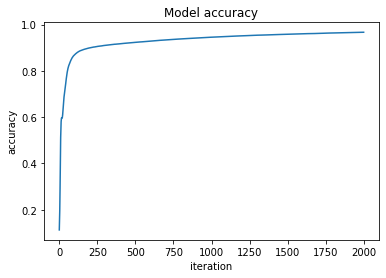

In [11]:
# Accuracy plot
plt.plot(report['accuracies'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.show()

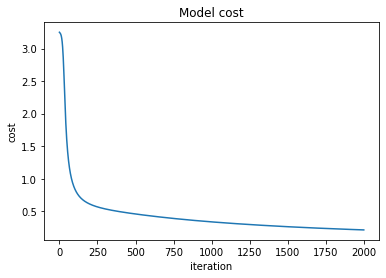

In [12]:
# Cost plot
plt.plot(report['costs'])
plt.title('Model cost')
plt.ylabel('cost')
plt.xlabel('iteration')
plt.show()

## Evaluation

In [13]:
y_predict, cache = forward_propagate(X_test, parameters)
test_accuracy = compute_accuracy(y_predict, Y_test)
loss, test_cost = cee(y_predict, Y_test)
print('Accuracy on test dataset:', test_accuracy)
print('Cost on test dataset:', test_cost)

Accuracy on test dataset: 0.9621
Cost on test dataset: 0.22708709111112546
